#Libraries

In [11]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [12]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

import math

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

#new augmentation import
import keras_cv as tfkcv
from keras_cv import layers as tfkcvl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
# import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


In [4]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Preprocessing

In [5]:
# Import data

data = np.load('/content/drive/MyDrive/Università/ANN/training_set.npz')
column_names = data.files
print(column_names)
images = data['images']
labels = data['labels']

# Convert values in data to int
# images = images.astype(int)

print(images.size) # The images are between 0 and 255
print(labels.size)

# We need to reshape the images!
images = images.reshape(13759, 96, 96, 3)
print(images.shape)

['images', 'labels']
380408832
13759
(13759, 96, 96, 3)


In [6]:
# Flatten labels to 1D if they are in a higher-dimensional structure
labels_flat = np.ravel(labels)

# Count occurrences of each class
class_counts = np.bincount(labels_flat, minlength=8)

# Display counts for each class
for class_id, count in enumerate(class_counts):
    print(f"Class {class_id}: {count}")

Class 0: 1052
Class 1: 2381
Class 2: 1285
Class 3: 2226
Class 4: 1049
Class 5: 1393
Class 6: 2530
Class 7: 1843


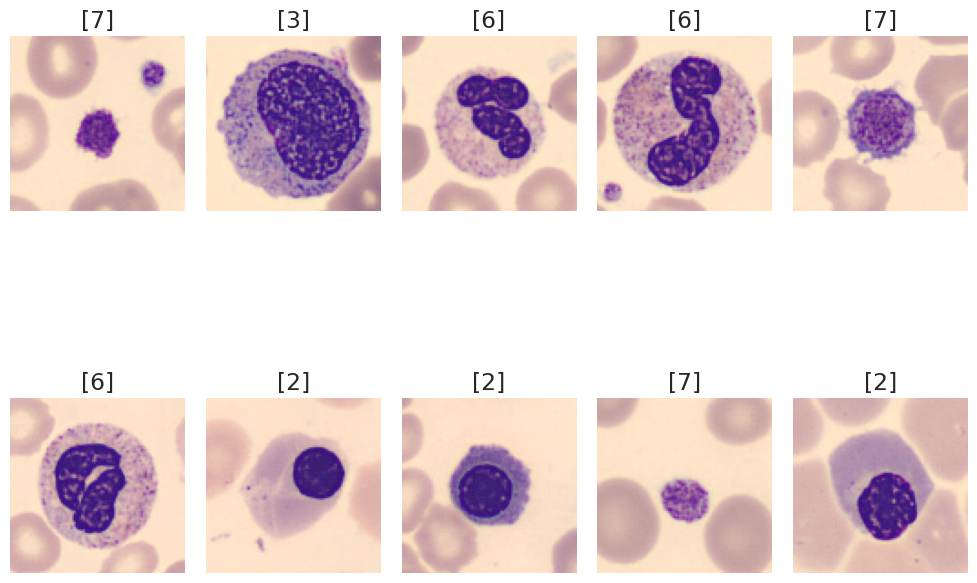

In [7]:
# Visualisation of first 10 images
fig , axes = plt.subplots(2,5, figsize = (10,9))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(images[i])
    # axes[i].imshow(np.clip(images[i], 0, 255))
    axes[i].axis('off')
    axes[i].set_title(labels[i])

plt.tight_layout()

In [8]:
h, w, c = images[0].shape
images_flat = images.reshape((13759, h*w*c))
print(images_flat.shape)

(13759, 27648)


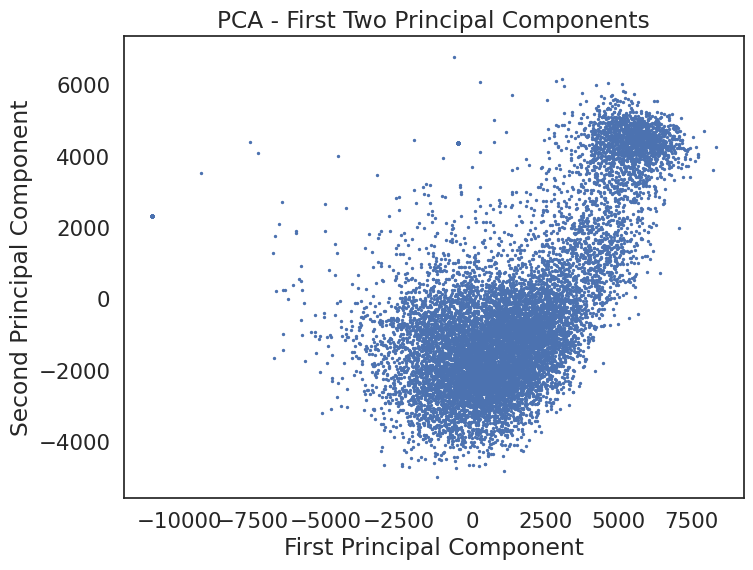

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_flat)

# Plot the first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], s=2)
plt.title("PCA - First Two Principal Components")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

Number of outliers: 1602
Unique outliers:  3


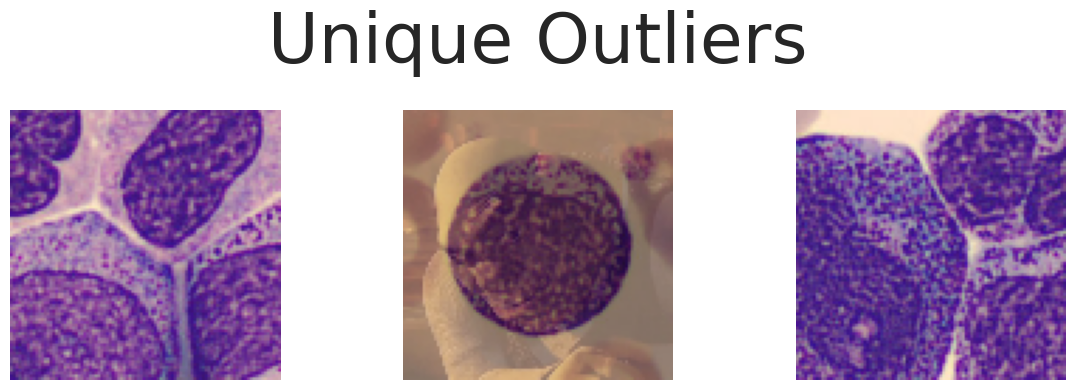

In [10]:
# Find outliers
# First outlier
outliers_y = (images_pca[:,1] > 35000) + (images_pca[:,1] < -50000)         # or
outliers_x = (images_pca[:,0] > 50000) + (images_pca[:,0] < -7500)


outliers_1 = np.logical_or(outliers_x, outliers_y)

# Visualisation of outliers
unique_outliers_1 = np.unique(images[outliers_1], axis=0)
print(f"Number of outliers: {len(images[outliers_1])}")


num_outliers = len(unique_outliers_1)
print("Unique outliers: ", num_outliers)
cols = min(10, num_outliers)  # Set a maximum number of columns
rows = math.ceil(num_outliers / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten() if num_outliers > 1 else [axes]


for i, outlier in enumerate(unique_outliers_1):
    axes[i].imshow(outlier)
    axes[i].axis('off')

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Unique Outliers', fontsize=50)
plt.tight_layout()
plt.show()

In [ ]:
# t-SNE for anomaly detection
h, w, c = images[0].shape
images_flat = images.reshape((13759, h*w*c))
print(images_flat.shape)
scores_tsne = TSNE(n_components=2,perplexity=70).fit_transform(images_flat)

plt.figure(figsize=[10,10])
plt.title('t-SNE')
plt.plot(scores_tsne[:,0],scores_tsne[:,1], 'g.')
plt.show()

(13759, 27648)


In [16]:
# Find outliers
# First outlier
# NOTE: cambiato il primo valore da 35 a 30
outliers_y = (scores_tsne[:,1] > 30) + (scores_tsne[:,1] < -50)         # or
outliers_x = (scores_tsne[:,0] > 50) + (scores_tsne[:,0] < -50)


outliers_1 = np.logical_or(outliers_x, outliers_y)

# Visualisation of outliers
unique_outliers_1 = np.unique(images[outliers_1], axis=0)
print(f"Number of outliers: {len(images[outliers_1])}")


num_outliers = len(unique_outliers_1)
print("Unique outliers: ", num_outliers)
cols = min(10, num_outliers)  # Set a maximum number of columns
rows = math.ceil(num_outliers / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten() if num_outliers > 1 else [axes]


for i, outlier in enumerate(unique_outliers_1):
    axes[i].imshow(outlier)
    axes[i].axis('off')

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Unique Outliers', fontsize=50)
plt.tight_layout()
plt.show()

NameError: name 'scores_tsne' is not defined

In [15]:
# Second Outlier
outliers_y = (scores_tsne[:,1] > 10) * (scores_tsne[:,0] < -35)         # x* y
outliers_x = (scores_tsne[:,0] > 50) + (scores_tsne[:,0] < -50)


outliers_2 = np.logical_or(outliers_x, outliers_y)

# Visualisation of outliers
unique_outliers_2 = np.unique(images[outliers_2], axis=0)
print(f"Number of outliers: {len(images[outliers_2])}")


num_outliers = len(unique_outliers_2)
print("Unique outliers: ", num_outliers)
cols = min(10, num_outliers)  # Set a maximum number of columns
rows = math.ceil(num_outliers / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten() if num_outliers > 1 else [axes]


for i, outlier in enumerate(unique_outliers_2):
    axes[i].imshow(outlier)
    axes[i].axis('off')

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Unique Outliers', fontsize=50)
plt.tight_layout()
plt.show()

NameError: name 'scores_tsne' is not defined

In [14]:
# Here we find the indexes of the outliers and remove them and all their copies from the data
outliers_idx = np.where(outliers_2 == 1)[0]
# for i in range(20):
#   print(outliers_idx[i])               # To see the indexes of the outliers

rick = 13571
wtf = 11962

# Displaying the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the Rick image
axes[0].imshow(images[rick])
axes[0].set_title('Rick image')
axes[0].axis('off')  # Hide axes for clarity

# Display the WTF image
axes[1].imshow(images[wtf])
axes[1].set_title('WTF image')
axes[1].axis('off')  # Hide axes for clarity

plt.tight_layout()
plt.show()

NameError: name 'outliers_2' is not defined

In [13]:
# On T-Sne plot
rick = np.array([np.array_equal(i, images[rick]) for i in images])
wtf = np.array([np.array_equal(i, images[wtf]) for i in images])
# print(images.shape)

to_remove = rick + wtf


plt.figure(figsize=(10,9))
plt.plot(scores_tsne[~ to_remove,0],scores_tsne[~ to_remove,1], 'g.')
plt.plot(scores_tsne[rick,0], scores_tsne[rick,1],'b.')
plt.plot(scores_tsne[wtf,0],scores_tsne[wtf,1],'r.')
plt.legend(['cells','rick','wtf'])
plt.show()

NameError: name 'rick' is not defined

#Data cleaning

In [12]:
print(f"Size before removing outliers: {images.shape[0]}")

to_keep = ~ to_remove

images_cleaned = images[to_keep]
labels_cleaned = labels[to_keep]

print(f"Size after removing outliers: {images_cleaned.shape[0]}")

# Removed doubles
unique_images, idx_unique = np.unique(images_cleaned, return_index= True, axis=0)

print(f"Size before removing doubles: {images_cleaned.shape[0]}")

labels_cleaned = labels_cleaned[idx_unique]
images_cleaned = images_cleaned[idx_unique]
count = len(images_cleaned)
labels_unique = np.unique(labels_cleaned)


print(labels_unique)
print(f"Size after removing doubles: {count}")

Size before removing outliers: 13759


NameError: name 'to_remove' is not defined

#Loading for NN

In [16]:
from sklearn.utils import resample
from collections import Counter

def balance_data_oversample(images, labels):
    # Count the samples per class and determine the maximum class count
    # Convert labels to a 1D array to make it hashable
    labels = labels.ravel()  # Flatten the labels array
    class_counts = Counter(labels)
    max_count = max(class_counts.values())

    # Separate images and labels by class
    balanced_images = []
    balanced_labels = []

    for label in np.unique(labels):
        images_class = images[labels == label]

        # Oversample to match the maximum class count
        images_balanced = resample(images_class, replace=True, n_samples=max_count, random_state=0)

        # Collect balanced data
        balanced_images.append(images_balanced)
        balanced_labels.append([label] * len(images_balanced))

    # Concatenate all balanced classes
    balanced_images = np.vstack(balanced_images)
    balanced_labels = np.concatenate(balanced_labels)

    print(f"Balanced dataset size: {balanced_images.shape[0]}")
    print(f"Class distribution after balancing: {Counter(balanced_labels)}")

    return balanced_images, balanced_labels

In [17]:
# Import data
def load_data():
    data = np.load('/content/drive/MyDrive/Università/ANN/training_set.npz')

    images = data['images']
    labels = data['labels']

    # Convert values in data to int
    images = images.astype(int)

    rick = 13571
    wtf = 11962

    rick  = np.array([np.array_equal(i, images[rick]) for i in images])
    wtf = np.array([np.array_equal(i, images[wtf]) for i in images])

    # Finding label to remove
    to_remove = wtf + rick

    print(f"Size before removing outliers: {images.shape[0]}")

    # Removing outliers
    to_keep = ~ to_remove

    images_cleaned = images[to_keep]
    labels_cleaned = labels[to_keep]

    print(f"Size after removing outliers: {images_cleaned.shape[0]}")

    # Remove doubles
    unique_images, idx_unique = np.unique(images_cleaned, return_index= True, axis=0)

    print(f"Size before removing doubles: {images_cleaned.shape[0]}")

    labels_cleaned = labels_cleaned[idx_unique]
    images_cleaned = images_cleaned[idx_unique]
    count = len(images_cleaned)
    labels_unique = np.unique(labels_cleaned)


    print(labels_unique)
    print(f"Size after removing doubles: {count}")

    return images_cleaned, labels_cleaned

data, labels = load_data()

data, labels = balance_data_oversample(data, labels)

Size before removing outliers: 13759
Size after removing outliers: 11959
Size before removing doubles: 11959
[0 1 2 3 4 5 6 7]
Size after removing doubles: 11951
Balanced dataset size: 18640
Class distribution after balancing: Counter({0: 2330, 1: 2330, 2: 2330, 3: 2330, 4: 2330, 5: 2330, 6: 2330, 7: 2330})


In [18]:
# Flatten labels to 1D if they are in a higher-dimensional structure
labels_flat = np.ravel(labels)

# Count occurrences of each class
class_counts = np.bincount(labels_flat, minlength=8)

# Display counts for each class
for class_id, count in enumerate(class_counts):
    print(f"Class {class_id}: {count}")

Class 0: 2330
Class 1: 2330
Class 2: 2330
Class 3: 2330
Class 4: 2330
Class 5: 2330
Class 6: 2330
Class 7: 2330


#Encoding labels and splitting the data

In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split


# one-hot encoding labeling
label_encoder = LabelEncoder()
# This converts to a vector of 0s and 1s
labels_enc = label_encoder.fit_transform(labels)
# This creates the one-hot encoding
train_lbl = tfk.utils.to_categorical(labels_enc)

# print(labels_enc)
# for i in range(len(labels_enc)):
#     print(f"{labels[i]}: {labels_enc[i]}")

for i in range(5):
    print(f"{labels[i]}: {train_lbl[i]}")

0: [1. 0. 0. 0. 0. 0. 0. 0.]
0: [1. 0. 0. 0. 0. 0. 0. 0.]
0: [1. 0. 0. 0. 0. 0. 0. 0.]
0: [1. 0. 0. 0. 0. 0. 0. 0.]
0: [1. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
# Split
X = data
y = train_lbl
split = 0.2         # Train validation split

# # Split data into train_val and test sets
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed,
#                                                             test_size=300, stratify=np.argmax(y,axis=1))

# # Further split train_val into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed,
#                                                   test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# We don't need a test set (or maybe we do)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed,
                                                  test_size=0.2, stratify=np.argmax(y,axis=1),
                                                  shuffle=True)         # Remember to shuffle!


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
# print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (14912, 96, 96, 3), y_train shape: (14912, 8)
X_val shape: (3728, 96, 96, 3), y_val shape: (3728, 8)


#Define network Parameters and build the model

In [21]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


#CNN

##Build the model (CNN)

In [60]:
# Number of training epochs
# epochs = 1000
epochs = 100

# Batch size for training
batch_size = 32

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 100
Batch Size: 32
Learning Rare: 0.001


In [61]:
# VGG-inspired model
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    augmentation=None,
    seed=seed
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Apply optional data augmentation, then first convolutional layer
    if augmentation == None:
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(input_layer)
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv01')(x)
    else:
        x = augmentation(input_layer)
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(x)
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv01')(x)

    # Apply activation and pooling after the first convolution
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    # Apply second convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv10')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    # Apply third convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv20')(x)
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv21')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    # Apply fourth convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv30')(x)
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv31')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)                  # Gap instead of flatten!!!!

    # Define the output layer with softmax activation for classification
    output_layer = tfkl.Dense(units=output_shape, activation='softmax', name='Output')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model with categorical crossentropy loss and Adam optimizer
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the compiled model
    return model

In [81]:
# Augmentation for the model
# Define a sequential model for image augmentation with various transformations
augmentation_all = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='Augmentation')


# A selection of augmentations (parameters should be tuned) TODO: try smaller parameters or remove or add some transformations
augmentation = tf.keras.Sequential([  ##STA USANDO QUESTO
    tfkl.RandomFlip(),
    tfkl.RandomRotation(factor=0.4),
    tfkl.RandomContrast(0.2),
    tfkl.RandomTranslation(0.2, 0.2),
], name='preprocessing')





Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_29 (RandomFlip)    │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_29          │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 96, 96, 16)           │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv01 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv0 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv01 (Conv2D)                    │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 96, 96, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 48, 48, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 48, 48, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv10 (Conv2D)                     │ (None, 48, 48, 32)           │         9,248 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 24, 24, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 24, 24, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv20 (Conv2D)                     │ (None, 24, 24, 64)           │        36,928 │    Y    │
├──────────────────────

 Total params: 483,704 (1.85 MB)

 Trainable params: 483,704 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

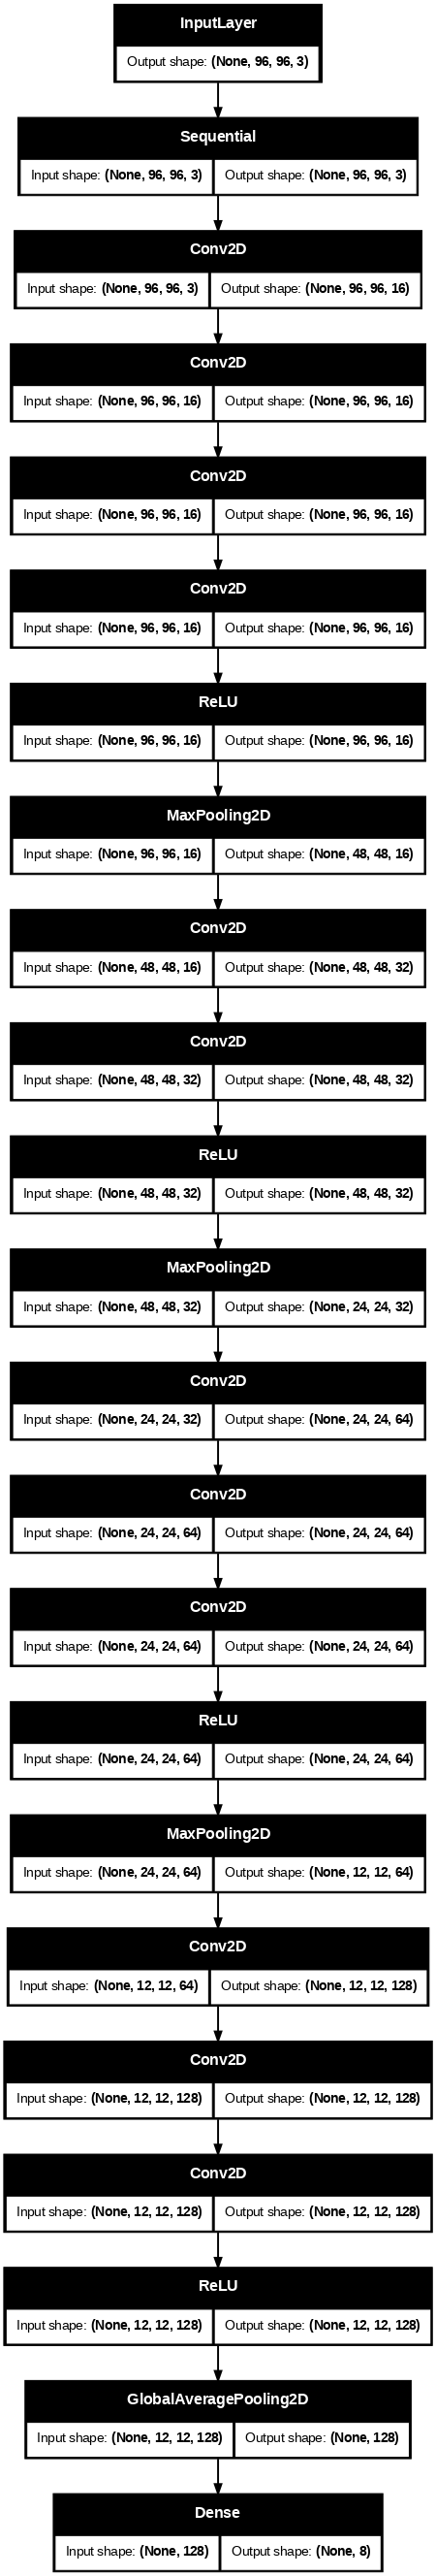

In [82]:
# Build the model with specified input and output shapes
model = build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    augmentation=augmentation,
    seed=seed
    )

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
# tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True, dpi=70)

In [83]:
# Define the patience value for early stopping
patience = 10

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [84]:
def runCnn(model):
  history = model.fit(
      x=X_train,
      y=y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(X_val, y_val),
      callbacks=callbacks
  ).history

  # Calculate and print the final validation accuracy
  final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
  print(f'Final validation accuracy: {final_val_accuracy}%')

  # Save the trained model to a file with the accuracy included in the filename
  model_filename = 'CNN_'+str(final_val_accuracy)+'.keras'
  model.save(model_filename)

  # Delete the model to free up resources
  del model
  return final_val_accuracy

In [85]:
import copy
#prova di diversi aug
results=[]

augmentation_cv_vector = [
    tfk.Sequential([
      tfkcvl.ChannelShuffle(groups=3, seed=seed),
    ]),
    tfk.Sequential([
      tfkcvl.RandomCutout(height_factor=0.05, width_factor=0.05, fill_mode="constant", fill_value=0.0, seed=seed),
    ]),
    tfk.Sequential([
      tfkcvl.RandomHue((0.01,0.5), value_range=[0, 1], seed=seed),
    ]),
    tfk.Sequential([
      tfkcvl.JitteredResize((96,96),(0.8, 1.25),(96,96),"xywh","bilinear",seed=seed)
    ]),
    tfk.Sequential([
      tfkcvl.RandomSaturation((0.01,0.5), seed=seed),
    ]),
    tfk.Sequential([
      tfkcvl.RandomSharpness((0.01,0.5), value_range=[0, 1], seed=seed),
    ]),
]

for augmentation_cv_e in augmentation_cv_vector:
  tmpaugmentation = copy.deepcopy(augmentation)
  tmpaugmentation.add(augmentation_cv_e)
  model = build_model(
        input_shape=input_shape,
        output_shape=output_shape,
        learning_rate=learning_rate,
        augmentation=tmpaugmentation,
        seed=seed
      )

  # Display a summary of the model architecture
  model.summary(expand_nested=True, show_trainable=True)

  # Plot the model architecture
  # tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)
  tfk.utils.plot_model(model, expand_nested=True, show_shapes=True, dpi=70)

  results.append(runCnn(model))

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_29 (RandomFlip)    │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_29          │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ sequential_78 (Sequential)     │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│       └ channel_shuffle_11          │ (None, 96, 96, 3)            │             0 │    -    │
│ (ChannelShuffle)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 96, 96, 16)           │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv01 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv0 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv01 (Conv2D)                    │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 96, 96, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 48, 48, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 48, 48, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv10 (Conv2D)                     │ (None, 48, 48, 32)           │         9,248 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)   

 Total params: 483,704 (1.85 MB)

 Trainable params: 483,704 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.1858 - loss: 3.1685 - val_accuracy: 0.4088 - val_loss: 1.6088
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5003 - loss: 1.2892 - val_accuracy: 0.6239 - val_loss: 0.9467
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6733 - loss: 0.8709 - val_accuracy: 0.7508 - val_loss: 0.6568
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7326 - loss: 0.7001 - val_accuracy: 0.8061 - val_loss: 0.5265
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7756 - loss: 0.6134 - val_accuracy: 0.8267 - val_loss: 0.5029
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7986 - loss: 0.5550 - val_accuracy: 0.8417 - val_loss: 0.4759
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8201 - loss: 0.4976 - val_accuracy: 0.8294 - val_loss: 0.5090
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8312 - loss: 0.4745 -

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_29 (RandomFlip)    │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_29          │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ sequential_79 (Sequential)     │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│       └ random_cutout_12            │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomCutout)                      │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 96, 96, 16)           │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv01 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv0 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv01 (Conv2D)                    │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 96, 96, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 48, 48, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 48, 48, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv10 (Conv2D)                     │ (None, 48, 48, 32)           │         9,248 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)   

 Total params: 483,704 (1.85 MB)

 Trainable params: 483,704 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.2672 - loss: 3.5616 - val_accuracy: 0.4418 - val_loss: 1.5829
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6254 - loss: 1.0035 - val_accuracy: 0.8514 - val_loss: 0.4599
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8227 - loss: 0.5138 - val_accuracy: 0.8611 - val_loss: 0.3959
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8714 - loss: 0.3730 - val_accuracy: 0.9021 - val_loss: 0.2507
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8812 - loss: 0.3449 - val_accuracy: 0.9117 - val_loss: 0.2621
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9103 - loss: 0.2634 - val_accuracy: 0.9447 - val_loss: 0.1610
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9149 - loss: 0.2522 - val_accuracy: 0.8490 - val_loss: 0.4638
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8357 - loss: 0.4940 -

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_29 (RandomFlip)    │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_29          │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ sequential_80 (Sequential)     │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│       └ random_hue_12 (RandomHue)   │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 96, 96, 16)           │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv01 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv0 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv01 (Conv2D)                    │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 96, 96, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 48, 48, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 48, 48, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv10 (Conv2D)                     │ (None, 48, 48, 32)           │         9,248 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 24, 24, 32)           │             0 │    -    │
├──────────────────────

 Total params: 483,704 (1.85 MB)

 Trainable params: 483,704 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1209 - loss: 2.0823 - val_accuracy: 0.1250 - val_loss: 2.0796
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1187 - loss: 2.0802 - val_accuracy: 0.1250 - val_loss: 2.0795
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1160 - loss: 2.0796 - val_accuracy: 0.1250 - val_loss: 2.0795
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1147 - loss: 2.0796 - val_accuracy: 0.1250 - val_loss: 2.0795
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1148 - loss: 2.0796 - val_accuracy: 0.1250 - val_loss: 2.0795
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1151 - loss: 2.0796 - val_accuracy: 0.1250 - val_loss: 2.0795
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1144 - loss: 2.0796 - val_accuracy: 0.1250 - val_loss: 2.0795
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1138 - loss: 2.0796 -

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_29 (RandomFlip)    │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_29          │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ sequential_81 (Sequential)     │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│       └ jittered_resize_11          │ (None, 96, 96, 3)            │             0 │    -    │
│ (JitteredResize)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 96, 96, 16)           │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv01 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv0 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv01 (Conv2D)                    │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 96, 96, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 48, 48, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 48, 48, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv10 (Conv2D)                     │ (None, 48, 48, 32)           │         9,248 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)   

 Total params: 483,704 (1.85 MB)

 Trainable params: 483,704 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.2549 - loss: 3.4591 - val_accuracy: 0.6116 - val_loss: 1.0118
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.6530 - loss: 0.9448 - val_accuracy: 0.8635 - val_loss: 0.4330
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.8222 - loss: 0.5078 - val_accuracy: 0.8492 - val_loss: 0.4346
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.8689 - loss: 0.3711 - val_accuracy: 0.9056 - val_loss: 0.2790
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.8855 - loss: 0.3386 - val_accuracy: 0.9445 - val_loss: 0.1779
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.8882 - loss: 0.3161 - val_accuracy: 0.8686 - val_loss: 0.4107
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.8969 - loss: 0.3091 - val_accuracy: 0.7749 - val_loss: 0.7028
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.8820 - loss: 0

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_29 (RandomFlip)    │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_29          │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ sequential_82 (Sequential)     │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│       └ random_saturation_12        │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomSaturation)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 96, 96, 16)           │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv01 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv0 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv01 (Conv2D)                    │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 96, 96, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 48, 48, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 48, 48, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv10 (Conv2D)                     │ (None, 48, 48, 32)           │         9,248 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)   

 Total params: 483,704 (1.85 MB)

 Trainable params: 483,704 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.1301 - loss: 3.5958 - val_accuracy: 0.1247 - val_loss: 2.0827
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1315 - loss: 2.0776 - val_accuracy: 0.1271 - val_loss: 2.0793
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1348 - loss: 2.0745 - val_accuracy: 0.1153 - val_loss: 2.0797
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1213 - loss: 2.0792 - val_accuracy: 0.1298 - val_loss: 2.0795
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1164 - loss: 2.0797 - val_accuracy: 0.1242 - val_loss: 2.0795
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1321 - loss: 2.0757 - val_accuracy: 0.1403 - val_loss: 2.0706
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1586 - loss: 2.0564 - val_accuracy: 0.1250 - val_loss: 2.0801
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1195 - loss: 2.0802 -

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_29 (RandomFlip)    │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast_29             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_29          │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ sequential_83 (Sequential)     │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│       └ random_sharpness_12         │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomSharpness)                   │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 96, 96, 16)           │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv01 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv0 (Conv2D)                     │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Nconv01 (Conv2D)                    │ (None, 96, 96, 16)           │         2,320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 96, 96, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 48, 48, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 48, 48, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv10 (Conv2D)                     │ (None, 48, 48, 32)           │         9,248 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)   

 Total params: 483,704 (1.85 MB)

 Trainable params: 483,704 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.1123 - loss: 2.0820 - val_accuracy: 0.1250 - val_loss: 2.0796
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1194 - loss: 2.0803 - val_accuracy: 0.1250 - val_loss: 2.0795
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1147 - loss: 2.0802 - val_accuracy: 0.1250 - val_loss: 2.0795
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1255 - loss: 2.0797 - val_accuracy: 0.1250 - val_loss: 2.0797
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1215 - loss: 2.0802 - val_accuracy: 0.1250 - val_loss: 2.0795
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1248 - loss: 2.0795 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1152 - loss: 2.0796 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1147 - loss: 2.0796 -

In [86]:
results

[88.87, 95.73, 12.5, 94.45, 14.03, 12.5]